<a href="https://colab.research.google.com/github/orilib/PyTorch/blob/main/FacialKeypointsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Facial-keypoints-detection

This notebook is a solution for the facial-keypoints-detection Kaggle competition

https://www.kaggle.com/c/facial-keypoints-detection/overview/description

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

* tracking faces in images and video
* analysing facial expressions
* detecting dysmorphic facial signs for medical diagnosis
* biometrics / face recognition

### Settings and imports

In [1]:
TRAIN_RUN = False
TEST_RUN = not TRAIN_RUN
FIRST_TIME = False
EPOCHS_NUM = 50
GPU_FOR_TESTING = False

#### Imports

In [2]:
from google.colab import drive
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from math import cos, sin, pi
random_seed = 2021
torch.manual_seed(random_seed)

In [4]:
!pip -q install hiddenlayer
import hiddenlayer as hl

### Download Data from Kaggle
see - https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/PyTorchPractice"
# /content/gdrive/My Drive/Colab Notebook/PyTorchPractice is the path where kaggle.json is present in the Google Drive

In [7]:
#changing the working directory
%cd /content/drive/MyDrive/'Colab Notebooks'/PyTorchPractice/FacialKeypointsDetectionData

/content/drive/MyDrive/Colab Notebooks/PyTorchPractice/FacialKeypointsDetectionData


## Get data

#### First time only


In [8]:
if FIRST_TIME:
    os.system('kaggle competitions download -c facial-keypoints-detection')
#!kaggle competitions download -c facial-keypoints-detection

In [9]:
# %cd ./FacialKeypointsDetectionData
# !unzip ./training.zip -d train
#!ls

#### Data exploration

In [10]:
training_csv_name = 'training.csv'
training_csv_name_clean = 'training_clean.csv'
training_csv_name_fixed = 'training_fixed.csv'
df = pd.read_csv('training.csv')
df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [11]:
df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


Different count values to each feature - we can see many missing keypoints!

#### Data sample - image with key points

In [12]:
def show_image_keypoints(image, key_pts, pred_key_pts=None, mask=None, annotate=None):
    """Show image with keypoints and predicted keypoints"""
    if image.ndim == 3 and image.shape[0] > 1:
        if type(image) == torch.Tensor:            
            plt.imshow(image.cpu().permute(1, 2, 0), )    
        else:
            plt.imshow(image.transpose(1,2,0), )    
    else:
        plt.imshow(image.squeeze(), cmap='gray',)  
    #draw keypoints
    norm = image.shape[-1] if key_pts.flatten()[0] <= 1 else 1        
    if mask is not None:           
        key_pts = np.array([a for a, b in zip(key_pts.flatten(), mask.flatten()) if b]).reshape(-1,2)       
    plt.plot(key_pts[:, 0]*norm, key_pts[:, 1]*norm, '.', color='red', label='actual')
    if pred_key_pts is not None:
        plt.plot(pred_key_pts[:, 0]*norm, pred_key_pts[:, 1]*norm, '.', color='green', label='actual')    
    #add annotation to keypoints
    if annotate:
        key_pts_lables = ['left_eye_center', 'right_eye_center', \
            'left_eye_inner_corner', 'left_eye_outer_corner', 'right_eye_inner_corner', 'right_eye_outer_corner',\
            'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 'right_eyebrow_inner_end', 'right_eyebrow_outer_end', \
            'nose_tip', 'mouth_left_corner', 'mouth_right_corner',\
            'mouth_center_top_lip', 'mouth_center_bottom_lip']                
        if mask is not None:           
            key_pts_lables = [a for a, b in zip(key_pts_lables, mask.reshape(-1,2)[:,0]) if b]         
        for i in range(len(key_pts_lables)):         
            plt.annotate(key_pts_lables[i], (key_pts[i,0]*norm, key_pts[i,1]*norm), fontsize=10)        

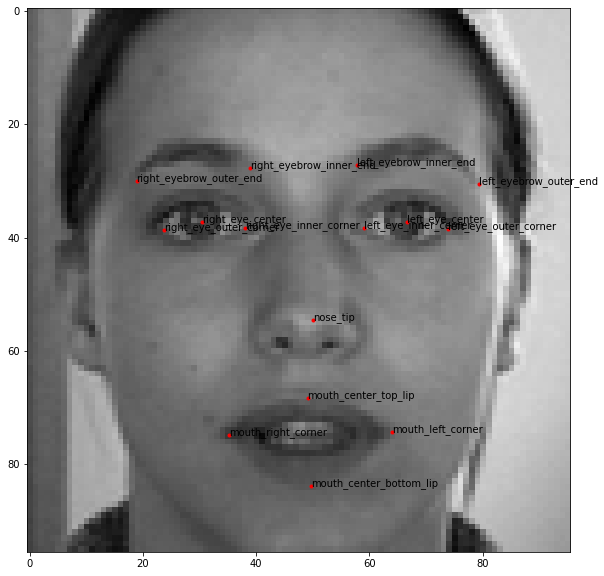

In [13]:
# draw given feature points over an image
img_inx = 12
image = df['Image'][img_inx]
# image is a string
image = image.split()
img_size = int(len(image) ** 0.5) # 96
# now image is a list
image = np.array(image,dtype=np.uint8)
# image is a numpy arrary
image = image.reshape(img_size,img_size)
key_pts = df.iloc[img_inx,:-1].to_numpy().reshape(-1,2)
plt.figure(figsize=(10, 10))
show_image_keypoints(image, key_pts, annotate=True)

###Handle missing Data

#### create a key points mask for valid points
to be used later as a mask on the loss function

In [14]:
valid_mask = df.notna()
valid_mask = valid_mask.to_numpy(dtype = 'int')
valid_mask = valid_mask[:,:30] # keypoints only mask
valid_mask = [" ".join(l.astype(str)) for l in valid_mask]

# add the mask as a new column on the dataframe
new_df = df
new_df['valid keys'] = valid_mask

In [15]:
new_df.iloc[-1][:-2]

left_eye_center_x            66.9383
left_eye_center_y            43.4245
right_eye_center_x           31.0961
right_eye_center_y           39.5286
left_eye_inner_corner_x          NaN
left_eye_inner_corner_y          NaN
left_eye_outer_corner_x          NaN
left_eye_outer_corner_y          NaN
right_eye_inner_corner_x         NaN
right_eye_inner_corner_y         NaN
right_eye_outer_corner_x         NaN
right_eye_outer_corner_y         NaN
left_eyebrow_inner_end_x         NaN
left_eyebrow_inner_end_y         NaN
left_eyebrow_outer_end_x         NaN
left_eyebrow_outer_end_y         NaN
right_eyebrow_inner_end_x        NaN
right_eyebrow_inner_end_y        NaN
right_eyebrow_outer_end_x        NaN
right_eyebrow_outer_end_y        NaN
nose_tip_x                   47.0693
nose_tip_y                   73.0333
mouth_left_corner_x              NaN
mouth_left_corner_y              NaN
mouth_right_corner_x             NaN
mouth_right_corner_y             NaN
mouth_center_top_lip_x           NaN
m

In [16]:
new_df.iloc[-1]['valid keys']

'1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1'

#### create new dataframes with filled missing values
on the missing places there will be average value of that category

In [17]:
fixed_df = new_df.fillna(method='ffill')
fixed_df.to_csv(training_csv_name_fixed, index = False)

### Data Loader


#### Dataset

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# inspired from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class FacialKeypointsDataset():    
    """Face Landmarks dataset."""
    def __init__(self, df, root_dir=None, transform=None, test=False):
        """
        Args:
            df (dataframe): dataframe of the dataframe table file with image, 
                keypoints and valid mask.            
            transform (callable, optional): Optional transform to be applied
                on a sample.
            test (bool, optional): if the dataset is for test - not includes 
                labels or not
        """        
        self.df = df                
        self.transform = transform      
        self.IMG_DIM = 96        
        self.test = test
        
    def __len__(self):
        return len(self.df)     
        
    def get_image(self, idx):                
        image = self.df.iloc[idx]['Image'].split()        
        image = np.array(image,dtype=np.float)/255
        image = np.repeat(image, 3) # create 3 channel image        
        image = image.reshape(self.IMG_DIM, self.IMG_DIM, 3)   
        image = transforms.ToTensor()(image)                
        return image.float().to(device)
        
    def get_landmark(self, idx):
        landmarks = self.df.iloc[idx, 0:30]        
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float32').reshape(-1, 2)/self.IMG_DIM                          
        return landmarks

    def get_landmark_maks(self, idx):
        landmarks_mask = self.df.iloc[idx, 31].split()             
        landmarks_mask = np.array(landmarks_mask,dtype=np.int).reshape(-1,2)
        # landmarks_mask = transforms.ToTensor()(landmarks_mask).to(device)
        return landmarks_mask

    def __getitem__(self, idx):        
        if torch.is_tensor(idx): idx = idx.tolist()             
        image           = self.get_image(idx)
        if self.test: return image.float()

        landmarks       = self.get_landmark(idx)
        landmarks_mask  = self.get_landmark_maks(idx)        
        sample = {'image': image, 'key_pts': landmarks, 'mask': landmarks_mask}        
        
        if self.transform: sample = self.transform(sample)

        sample['key_pts'] = transforms.ToTensor()(sample['key_pts']).to(device)
        sample['mask'] = transforms.ToTensor()(sample['mask']).to(device)        

        return sample             

#### create transforms for data augmentation

In [19]:
class facialRotation:
    def __init__(self, angle):
        assert angle <= 1.0 and angle >=0
        self.angle = angle
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        rotVal = random.uniform(-self.angle, self.angle)        
        newImg = transforms.functional.rotate(img, angle=-rotVal*180/pi)
        teta = rotVal
        rotMat = np.array([[cos(teta), sin(teta)],[-sin(teta), cos(teta)]])
        newKeyPts = np.dot(keyPts-[0.5,0.5],rotMat)+[0.5,0.5]        
        newKeyPts = newKeyPts.astype('float32')
        return {'image':newImg.float(), 'key_pts': newKeyPts, 'mask': mask}

class toTensor:
    def __init__(self):
        pass
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        imgToTensor = transforms.ToTensor()
        newImg = imgToTensor(img)
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class horizFlip:
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        if random.random() < self.p :
            newImg = transforms.functional.hflip(img)       
            newKeyPts = keyPts            
            left_right_reorder = [1,0,4,5,2,3,8,9,6,7,10,12,11,13,14]
            newKeyPts[:,0] = 1-newKeyPts[:,0]
            newKeyPts = newKeyPts[left_right_reorder, :]                        
        else:
            newImg = img
            newKeyPts = keyPts
        return {'image':newImg.float(), 'key_pts': newKeyPts, 'mask': mask}

class randomBrightness:
    def __init__(self):
        pass
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']         
        brightnessFact = 0.5*random.random()+0.75 #uniform ~[0.75,1.25]
        newImg = transforms.functional.adjust_brightness(img, brightnessFact)        
        # newKeyPts = keyPts
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class GaussianBlur:
    def __init__(self, kernel):
        self.kernel = kernel
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']             
        newImg = transforms.GaussianBlur(self.kernel)(img)
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']             
        newImg = transforms.Normalize(self.mean, self.std)(img)
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class Shift:
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']             
        if random.random() < self.p :            
            x_shift = random.choice([-12, 0, 12])
            y_shift = random.choice([-12, 0, 12])                    
            newImg = transforms.functional.affine(img = img, angle= 0, translate= [x_shift,y_shift], scale= 1, shear=0,)
            newKeyPts = keyPts
            newKeyPts[:,0] = newKeyPts[:,0]+x_shift/96
            newKeyPts[:,1] = newKeyPts[:,1]+y_shift/96            

            temp_mask = np.logical_and(newKeyPts>=0, newKeyPts<=1).astype(int)            
            temp_mask *= (temp_mask[:,0]*temp_mask[:,1]).reshape(-1,1)
            mask *= temp_mask
            np.clip(newKeyPts, 0, 1)
        else:
            newImg, newKeyPts = img, keyPts            
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class Scale:
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']             
        if random.random() < self.p :
            # perform scale by 1/2
            size = 96//2
            newImg = transforms.functional.resize(img = img, size = [size])
            newImg = transforms.functional.pad(img = newImg, padding=[size//2])
            newkeyPts = (keyPts-0.5)/2+0.5            
        else:
            newImg=img
            newkeyPts=keyPts
        return {'image':newImg.float(), 'key_pts': newkeyPts, 'mask': mask}

Common mistake - horizonat flip requires not only  that the keypoints values are converted, but also the role of the left-right points is flipped. for example left_eye_center_x (0.685, 0.398) is updated to (0.315, 0.398) but this is now the **right_eye_center_x**

In [20]:
# transforms pipeline
data_transform = transforms.Compose([    
    # randomBrightness(),
    GaussianBlur(3),
    horizFlip(0.5),    
    Scale(0.1),
    Shift(0.2),
    facialRotation(0.5),
    # Normalize((0.4897, 0.4897, 0.4897), (0.2330, 0.2330, 0.2330)),       
])

#### Instantiate dataset and visualize

In [21]:
def show_batch_samples(batch, img_number=8 ,ordered=True, dataloader=False):
    fig = plt.figure(figsize=(min(img_number,8)*3,5*max(img_number//8,1)))
    i=0
    batch_list = batch   
    plt.tight_layout() 
    while i < img_number:
        img_inx=i                
        if dataloader:
            if not ordered: img_inx = random.randrange(len(batch['image']))
            sample={}
            sample['image'], sample['key_pts'], sample['mask'] = batch['image'][img_inx], batch['key_pts'][img_inx], batch['mask'][img_inx]
        else:
            if not ordered: img_inx = random.randrange(len(batch))
            sample = batch_list[img_inx]                    
        if sample['key_pts'].ndim == 1: continue        
        ax = plt.subplot(max(img_number//8,1), min(img_number,8), i + 1)               
        ax.set_title('Sample #{}'.format(img_inx))
        ax.axis('off')            
        show_image_keypoints(sample['image'], sample['key_pts'], mask=sample['mask'])
        i+=1

    plt.show()    

we will use the csv with the filled data on the missing places

In [22]:
# split training/validation for 80/20
training_split = 0.2
input_df = pd.read_csv(training_csv_name_fixed)
split_arr = np.zeros(len(input_df),dtype=int)
split_arr[:int(training_split*len(input_df))] = 1
np.random.shuffle(split_arr)
input_df['valid_set'] = split_arr

train_df = input_df.loc[input_df['valid_set']==0]
valid_df = input_df.loc[input_df['valid_set']==1]
len(train_df), len(valid_df)

(5640, 1409)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


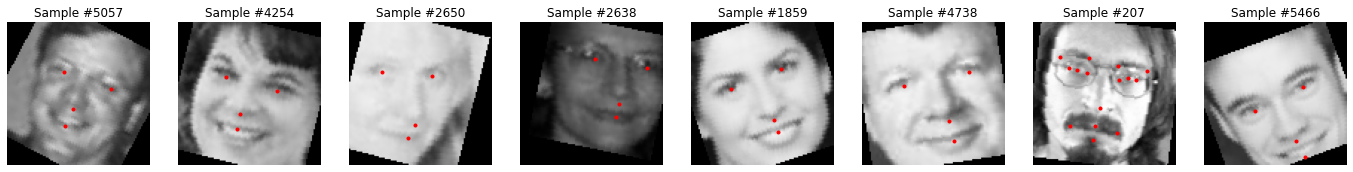

In [23]:
train_face_dataset = FacialKeypointsDataset(df=train_df, transform = data_transform)
val_face_dataset = FacialKeypointsDataset(df=valid_df, transform = None)

show_batch_samples(train_face_dataset, img_number=8, ordered=False, dataloader=False)

#### create dataloder

In [24]:
batch_size=32
dataloader = DataLoader(train_face_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = DataLoader(val_face_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

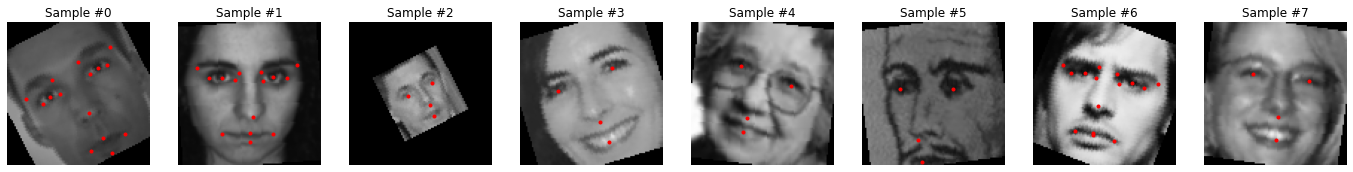

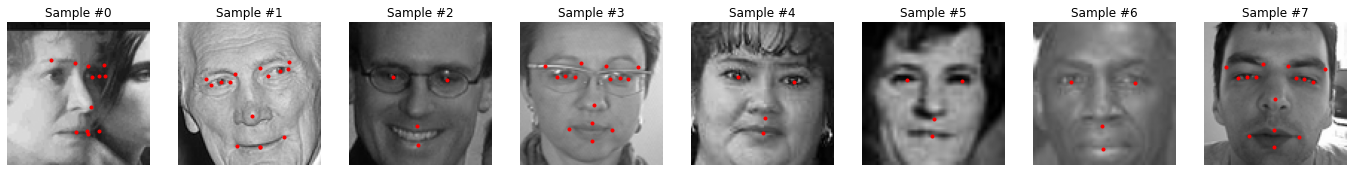

In [25]:
#show dataloader next mini batch
val_data_sample, train_data_sample = iter(dataloader_val).next(), iter(dataloader).next()
show_batch_samples(train_data_sample, img_number=8 ,ordered=True, dataloader=True)
show_batch_samples(val_data_sample, img_number=8 ,ordered=True, dataloader=True)

## Training settings

#### Define training function

The metric used as defined by Kaggle - root mean squere error (RMSE)

RMSE = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i -\hat{y_i}}\Big)^2}}$


In [26]:
def loss_to_RMSE(loss):
    return 96*(loss**0.5)

def testing(dataloader_val, criterion):
    ''' calulates the loss over validation set '''    
    model.eval()
    total_loss = 0            
    with torch.no_grad():
        for sample in dataloader_val: # run over the mini batches            
            images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']
            output = model(images)  
            output = output.view(-1, 1, 15, 2)          
            loss = criterion(output, keysPts, mask)            
            total_loss += loss.item()
    
    return total_loss/(len(dataloader_val))

def train_model(dataloader_train, dataloader_val, criterion, epochs=3, print_en=False, schedular=None):
    ''' train and test model given train dataloader, validation dataloader and epochs number '''
    itr = 1     
    # p_itr = 20        
    loss_list, val_loss_list = [], []    
    for epoch in range(epochs):
        total_loss = 0
        # itr_loss = 0
        model.train()        
        for sample in dataloader_train: # run over the mini batches            
            # get the inputs; data is a list of (inputs, keysPts, masks)
            images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(images)                           
            loss = criterion(output, keysPts, mask)            
            loss.backward()
            optimizer.step()                    
            total_loss += loss.item()          

        loss_list.append(total_loss/(len(dataloader_train)))
        val_loss = testing(dataloader_val, criterion)
        print('[Epoch {}/{}] -> train loss: {:.8f} train RMSE: {:.4f} Validation Loss: {:.8f}; Validation RMSE: {:.4f}'\
                        .format(epoch+1, epochs, loss_list[-1], loss_to_RMSE(loss_list[-1]), val_loss, loss_to_RMSE(val_loss)))
        val_loss_list.append(val_loss)
        if schedular is not None: scheduler.step()

    print('Finished Training')
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,5)
    ax1.plot(loss_list, label='train loss')
    ax1.plot(val_loss_list, label='val loss')    
    ax1.legend()
    ax1.set_title('Training and validation loss')
    train_acc_list = [loss_to_RMSE(loss) for loss in loss_list]
    val_acc_list = [loss_to_RMSE(val_loss) for val_loss in val_loss_list]    
    ax2.plot(train_acc_list, label='Train RMSE')    
    ax2.plot(val_acc_list, label='Validation RMSE')        
    ax2.set_title('Training and validation RMSE')
    ax2.legend()
    fig.show()
    print(f'Final training RMSE={loss_to_RMSE(loss_list[-1]):.4f}  final validation RMSE={loss_to_RMSE(val_loss_list[-1]):.4f}')


#### set training parameters

In [27]:
learning_rate=0.001 # baseline learning rate

# create custom loss function - MSE with mask
torch_MSE = torch.nn.MSELoss()
def masked_MSELoss(pred, gt, mask):    
    pred = pred * mask
    gt = gt * mask    
    return torch_MSE(pred, gt)

def non_masked_MSELoss(pred, gt, mask): 
    return torch_MSE(pred, gt)

criterion = non_masked_MSELoss

In [28]:
def save_model(model, path):
    torch.save(model.state_dict(), path)         
def load_model(model, path, device):
    model.load_state_dict(torch.load(path,map_location=torch.device(device)))


## 1. Custom Model

#### Define custom Model 1

In [ ]:
class NeuralNetwork(nn.Module):    
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)        
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)        
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)        
        self.bn5 = nn.BatchNorm2d(256)        
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1)        
        self.bn6 = nn.BatchNorm2d(256)                
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.dropout4 = nn.Dropout(0.25)
        self.dropout5 = nn.Dropout(0.25)
        self.dropout6 = nn.Dropout(0.25)
        self.dropout7 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):        
        # (3,96,96)
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))                        
        x = F.max_pool2d(x, 2)   # (16,48,48)
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))                                        
        x = F.max_pool2d(x, 2)   # (32,24,24)
        x = self.dropout3(F.relu(self.bn3(self.conv3(x))))                
        x = F.max_pool2d(x, 2)        # (64,12,12)
        x = self.dropout4(F.relu(self.bn4(self.conv4(x))))                
        x = F.max_pool2d(x, 2)
        x = self.dropout5(F.relu(self.bn5(self.conv5(x))))                        
        x = F.max_pool2d(x, 2) # (256,3,3)
        x = self.dropout6(x)        
        x = torch.flatten(x, 1) # (2304)        
        x = self.fc1(x)
        x = F.relu(x)        
        x = self.dropout7(x)
        x = self.fc2(x)                
        x = x.reshape(-1,1,15,2)
        output = x        
        return output

custom_model1 = NeuralNetwork()
custom_model1.to(device)

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

#### Visualize model
using hiddenlayer library

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


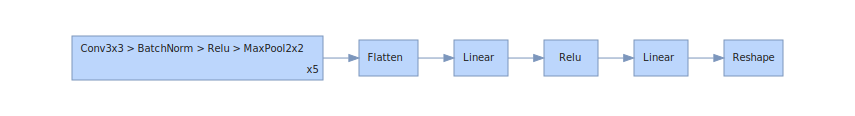

In [ ]:
graph_transforms = [ hl.transforms.Prune('Constant'), # Removes Constant nodes from graph.                    
                    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"), # Fold Conv, BN, RELU layers into one
                    hl.transforms.Fold("ConvBnRelu > MaxPool", "ConvBnReluMaxPool"),                    
                    hl.transforms.FoldDuplicates(),
                    ] 
sample = iter(dataloader).next()
custom_model1 = custom_model1.eval()
graph = hl.build_graph(custom_model1.to(device), sample['image'], transforms=graph_transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph

### Train Model

[Epoch 1/50] -> train loss: 0.07420629 train RMSE: 26.1512 Validation Loss: 0.02398869; Validation RMSE: 14.8688
[Epoch 2/50] -> train loss: 0.02411812 train RMSE: 14.9088 Validation Loss: 0.02526785; Validation RMSE: 15.2600
[Epoch 3/50] -> train loss: 0.01853939 train RMSE: 13.0713 Validation Loss: 0.02062796; Validation RMSE: 13.7879
[Epoch 4/50] -> train loss: 0.01402200 train RMSE: 11.3678 Validation Loss: 0.01372304; Validation RMSE: 11.2460
[Epoch 5/50] -> train loss: 0.01158165 train RMSE: 10.3313 Validation Loss: 0.00648024; Validation RMSE: 7.7280
[Epoch 6/50] -> train loss: 0.00930881 train RMSE: 9.2623 Validation Loss: 0.00738921; Validation RMSE: 8.2522
[Epoch 7/50] -> train loss: 0.00779398 train RMSE: 8.4752 Validation Loss: 0.00464666; Validation RMSE: 6.5440
[Epoch 8/50] -> train loss: 0.00630310 train RMSE: 7.6216 Validation Loss: 0.00404554; Validation RMSE: 6.1060
[Epoch 9/50] -> train loss: 0.00526618 train RMSE: 6.9666 Validation Loss: 0.00282947; Validation RMSE:

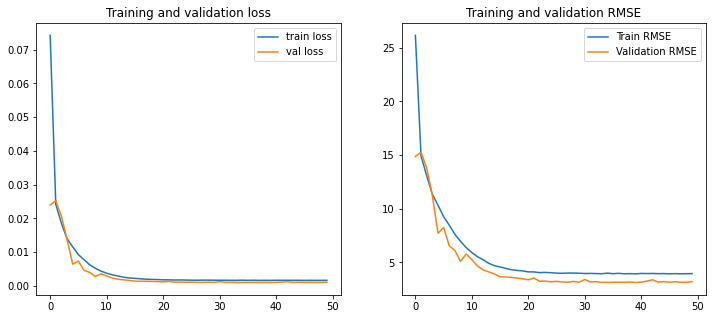

In [ ]:
model = custom_model1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
criterion = non_masked_MSELoss

if TRAIN_RUN:
    train_model(dataloader, dataloader_val, criterion=criterion, epochs=EPOCHS_NUM)    

We can see that the network converged well, the loss values of training and validation as well as the RMSE are too high.

In [ ]:
CUSTOM_MODEL1_PATH = './FacialKeypointsDetector_Model1.pth'
## if train_run mode save the model, if not load the model
if TRAIN_RUN:    
    save_model(model, CUSTOM_MODEL1_PATH)    
else:        
    model = NeuralNetwork()
    load_model(model, CUSTOM_MODEL1_PATH, device) 

_= model.eval() 

## 2. Pretrained resnet model
the training loss is too high -> the network is not deep enough to capture the complexity of the problem. 
we need a more complex model
pretrained ResNet18 is choosen as it is trained on imagenet and has learned similar basic image features.
we change the network end to our problem - 30 coordinates values of face keypoints


#### Use pretrained model - Resnet18

In [ ]:
def resnet18_model():
    model = models.resnet18(pretrained = True)
    num_ftrs = model.fc.in_features
    # add clasifier for 30 outputs
    # model.fc = nn.Linear(num_ftrs, 30)    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 30),
        nn.Unflatten(dim=1,unflattened_size=torch.Size([1,15,2]))
    )
    model=model.to(device)    
    return model

#### Resnet training


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



[Epoch 1/50] -> train loss: 0.02051599 train RMSE: 13.7505 Validation Loss: 0.00185576; Validation RMSE: 4.1355
[Epoch 2/50] -> train loss: 0.00193459 train RMSE: 4.2225 Validation Loss: 0.00148564; Validation RMSE: 3.7002
[Epoch 3/50] -> train loss: 0.00174200 train RMSE: 4.0068 Validation Loss: 0.00119313; Validation RMSE: 3.3160
[Epoch 4/50] -> train loss: 0.00173977 train RMSE: 4.0042 Validation Loss: 0.00149321; Validation RMSE: 3.7096
[Epoch 5/50] -> train loss: 0.00147925 train RMSE: 3.6923 Validation Loss: 0.00225807; Validation RMSE: 4.5618
[Epoch 6/50] -> train loss: 0.00153654 train RMSE: 3.7631 Validation Loss: 0.00213485; Validation RMSE: 4.4356
[Epoch 7/50] -> train loss: 0.00153505 train RMSE: 3.7613 Validation Loss: 0.00156394; Validation RMSE: 3.7965
[Epoch 8/50] -> train loss: 0.00129338 train RMSE: 3.4525 Validation Loss: 0.00379807; Validation RMSE: 5.9163
[Epoch 9/50] -> train loss: 0.00133731 train RMSE: 3.5106 Validation Loss: 0.00175776; Validation RMSE: 4.0249

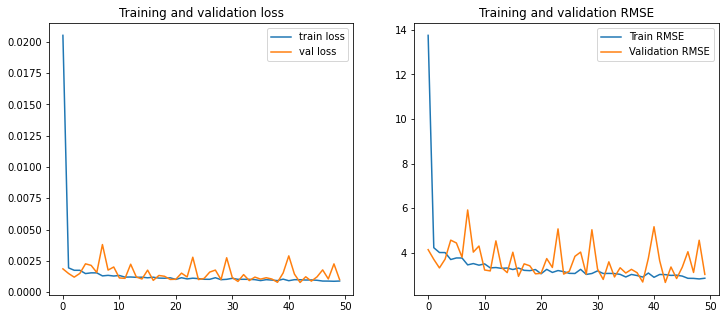

In [ ]:
model = resnet18_model()
criterion = non_masked_MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(dataloader, dataloader_val, criterion=criterion, epochs=EPOCHS_NUM)

We can see better loss and RMSE accruracy, though still a lot of room for improvement. Also the validation loss is not smooth and changes rapidly.

In [ ]:
MODEL2_PATH = './FacialKeypointsDetector_model2.pth'
## if train_run mode save the model, if not load the model
if TRAIN_RUN:    
    save_model(model, MODEL2_PATH)    
else:        
    model = resnet18_model()
    load_model(model, MODEL2_PATH, device) 

_= model.eval() 

#### Kaggle score = 3.38613


## Explore Validation loss 


#### arrange the validation set in decending loss order

In [41]:
## move the model to eval mode
GPU_FOR_TESTING=True
def create_RMSE_list(model, dataset):
    device_for_test = device if GPU_FOR_TESTING else 'cpu'
    model.to(device_for_test)         
    model.eval()

    dataloader_val_analize = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    loss_list = []
    for inx, sample in enumerate(dataloader_val_analize): # run over the mini batches            
        images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']    
        output = model(images.to(device_for_test)).view(-1, 1, 15, 2)       
        loss = loss_to_RMSE(criterion(output, keysPts, mask).item())            
        loss_list.append((inx, loss))
    loss_list.sort(key = lambda image: image[1], reverse=True)
    return loss_list


In [ ]:
loss_list = create_RMSE_list(model, val_face_dataset)
print(loss_list[:5])

[(442, 22.671285588748205), (383, 18.842705996615834), (398, 11.962639107687583), (445, 11.616604388237441), (670, 10.64430220331266)]


#### Validation set samples prediction vs ground truth
Samples with the highest error on the validation set

In [42]:
def show_dataset_RMSE(mode, dataset, masked = True):
    model.eval()
    loss_list = create_RMSE_list(model, dataset)    
    plt.figure(figsize=(24,8))
    plt.tight_layout()
    for i in range(min(len(loss_list),8)):        
        inx = loss_list[i][0]        
        sample = dataset[inx]
        image, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']    
        ax = plt.subplot(2, 8, i + 1)        
        ax.set_title('#{} RMSE: {:.2f}'.format(inx, loss_list[i][1]))
        ax.axis('off')        
        keyPtsPred = model(image.unsqueeze(0)).view(-1, 15, 2)   
        keysPts = keysPts.view(15, 2)
        mask = mask if masked else None
        show_image_keypoints(image, keysPts.cpu() ,keyPtsPred.squeeze(0).cpu().detach().numpy(), mask=mask)                
    plt.show()

#### show validation samples with highest RMSE

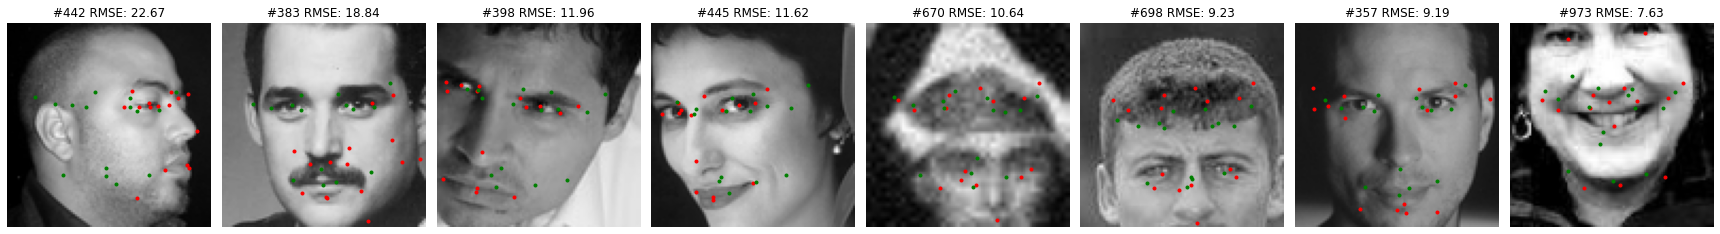

In [ ]:
show_dataset_RMSE(model, val_face_dataset, masked=False)

We can see bad results when:
* the ground truth key points are wrong due to complitin missing values (#383, #670, #698, #357, #973)
* face that is not not centered in the middle of the image (#698,#973)
* face that is looking to the side (#442,#445,#8)

on the next section the first prolem will be addressed

## 3. Custom loss function
With custom loss function the loss only refers to valid key points by setting all the non valid values to zero. 
This way we clear the noise from the training process and get better results.

Kaggle score = 1.99/1.68 (public/private)

result - Kaggle score = 1.91314

In [30]:
def masked_MSELoss(pred, gt, mask):    
    pred = pred * mask
    gt = gt * mask    
    return torch_MSE(pred, gt)

[Epoch 1/50] -> train loss: 0.01541473 train RMSE: 11.9190 Validation Loss: 0.00126620; Validation RMSE: 3.4160
[Epoch 2/50] -> train loss: 0.00107026 train RMSE: 3.1406 Validation Loss: 0.00097618; Validation RMSE: 2.9994
[Epoch 3/50] -> train loss: 0.00096041 train RMSE: 2.9751 Validation Loss: 0.00095144; Validation RMSE: 2.9612
[Epoch 4/50] -> train loss: 0.00089649 train RMSE: 2.8744 Validation Loss: 0.00105766; Validation RMSE: 3.1221
[Epoch 5/50] -> train loss: 0.00086388 train RMSE: 2.8216 Validation Loss: 0.00059206; Validation RMSE: 2.3359
[Epoch 6/50] -> train loss: 0.00075120 train RMSE: 2.6312 Validation Loss: 0.00092792; Validation RMSE: 2.9243
[Epoch 7/50] -> train loss: 0.00067558 train RMSE: 2.4952 Validation Loss: 0.00065859; Validation RMSE: 2.4637
[Epoch 8/50] -> train loss: 0.00060583 train RMSE: 2.3629 Validation Loss: 0.00050279; Validation RMSE: 2.1526
[Epoch 9/50] -> train loss: 0.00059543 train RMSE: 2.3425 Validation Loss: 0.00087640; Validation RMSE: 2.8420


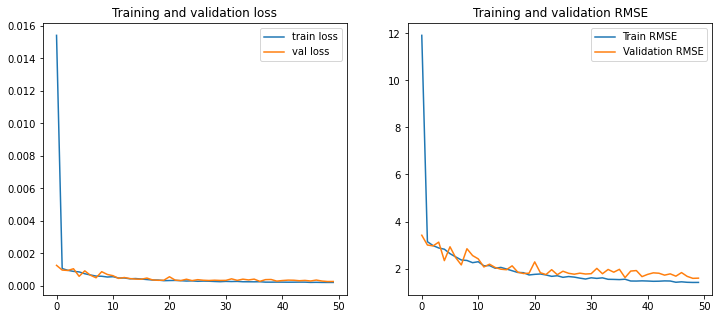

In [ ]:
criterion = masked_MSELoss
model = resnet18_model()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

train_model(dataloader, dataloader_val, criterion=criterion, epochs=EPOCHS_NUM)

In [ ]:
MODEL3_PATH = './FacialKeypointsDetector_model3.pth'
## if train_run mode save the model, if not load the model
if TRAIN_RUN:    
    save_model(model, MODEL3_PATH)    
else:     
    model = resnet18_model()   
    load_model(model, MODEL3_PATH, device) 

_= model.eval() 

we can see that the loss curves are not stable, it suggests that the learning rate is too high in some parts of the learning. next we'll try different values of learning rate as well as updating it on the way using scheduler.

## 4. Optimize the learning rate
* changing the learning rate value
* when using bigger base-line learning rate of 0.01 and 0.005 the convergence was worse at the first epochs
* starting at 0.0005 has proven to be better choise with gradual improving on the loss and RMSE values
* using scheduler to optimize the learning process
* using learning rate finder to get the best starting learning rate value
* with and without amsgrad on Adma optimizer

### learning rate finder
example taken from https://github.com/davidtvs/pytorch-lr-finder/blob/master/examples/lrfinder_cifar10_dataloader_iter.ipynb


In [32]:
pip install torch-lr-finder -q

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.54E-05


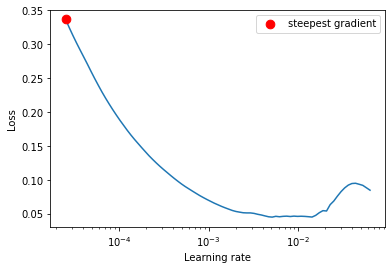

In [33]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
def run_lr_finder(model, start_lr=0.00001, end_lr=0.01):
    criterion = torch.nn.MSELoss()
    # model = resnet18_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    trainloader = dataloader

    class CustomTrainIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            return batch_data["image"], batch_data["key_pts"]
        
    custom_train_iter = CustomTrainIter(trainloader)

    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(custom_train_iter, start_lr=start_lr, end_lr=end_lr, num_iter=100)
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state

run_lr_finder(model, start_lr=0.000001, end_lr=0.01)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.33E-06


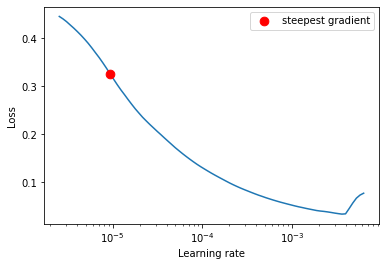

In [34]:
run_lr_finder(model, start_lr=0.000001, end_lr=0.01)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-04


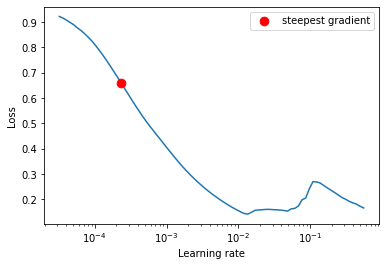

In [ ]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter

criterion = torch.nn.MSELoss()
model = resnet18_model()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trainloader = dataloader

class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data["image"], batch_data["key_pts"]
    
custom_train_iter = CustomTrainIter(trainloader)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(custom_train_iter, start_lr=0.00001, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
lr_finder.history['loss']
best_loss = lr_finder.best_loss
inx = lr_finder.history['loss'].index(best_loss)
best_lr = lr_finder.history['lr'][inx]
best_lr/10

0.0013530477745798076

Seems like values of about 1.0E-04 - 1.0E-03 should work well.


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.39E-04


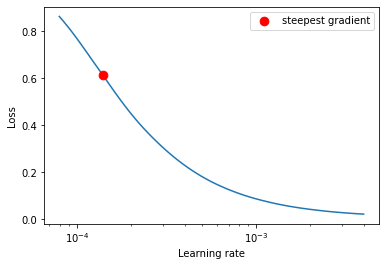

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(custom_train_iter, start_lr=0.00005, end_lr=0.005, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### 4.1 use learning rate/10 and scheduler
here the use pf amsgrad was not contributing to the convergence

Adjusting learning rate of group 0 to 1.0000e-04.
[Epoch 1/50] -> train loss: 0.03876429 train RMSE: 18.9011 Validation Loss: 0.00322625; Validation RMSE: 5.4528
Adjusting learning rate of group 0 to 9.7000e-05.
[Epoch 2/50] -> train loss: 0.00216416 train RMSE: 4.4660 Validation Loss: 0.00191111; Validation RMSE: 4.1968
Adjusting learning rate of group 0 to 9.4090e-05.
[Epoch 3/50] -> train loss: 0.00148038 train RMSE: 3.6937 Validation Loss: 0.00148122; Validation RMSE: 3.6947
Adjusting learning rate of group 0 to 9.1267e-05.
[Epoch 4/50] -> train loss: 0.00116281 train RMSE: 3.2736 Validation Loss: 0.00126716; Validation RMSE: 3.4173
Adjusting learning rate of group 0 to 8.8529e-05.
[Epoch 5/50] -> train loss: 0.00104089 train RMSE: 3.0972 Validation Loss: 0.00113811; Validation RMSE: 3.2386
Adjusting learning rate of group 0 to 8.5873e-05.
[Epoch 6/50] -> train loss: 0.00094256 train RMSE: 2.9473 Validation Loss: 0.00100511; Validation RMSE: 3.0435
Adjusting learning rate of group 

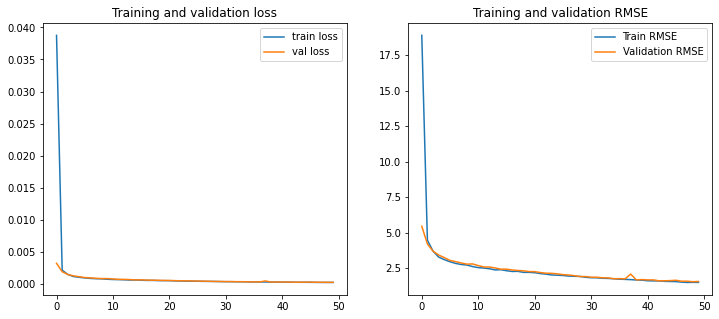

In [ ]:
criterion = masked_MSELoss
model = resnet18_model()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97, verbose=True)

train_model(dataloader, dataloader_val, criterion=criterion, epochs=EPOCHS_NUM, schedular=scheduler)

we can see that the training and validation losses are much more stable than before

In [ ]:
MODEL4_PATH = './FacialKeypointsDetector_model4.pth'
## if train_run mode save the model, if not load the model
if TRAIN_RUN:    
    save_model(model, MODEL4_PATH)    
else:        
    model = resnet18_model()
    load_model(model, MODEL4_PATH, device) 

_= model.eval() 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## 5. Pretrained ResNet take 2
* remove the last FC and the global average pooling
add instead 2 FC layers
* attempts to freeze parts of the network - unfreezing all gives the best result
* attempts to train from scratch, the pretrained model gives better results
* using new augmentations - shift and scale slightly improved the results
* using resnet50 gives similar results

### set new resnet model

In [29]:
def resnet18_model_new():
    model = models.resnet18(pretrained = True)
    # remove average pooling layer
    model.avgpool = nn.Sequential()
    # add FC layer from the last feature maps of size 3x3
    num_ftrs = model.fc.in_features*3*3    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        # nn.Dropout(p=0.1),
        # add clasifier for 30 outputs    
        nn.Linear(512, 30),
        nn.Unflatten(dim=1,unflattened_size=torch.Size([1,15,2]))
    )
    model=model.to(device)    
    return model

def resnet50_model_new():
    model = models.resnet50(pretrained = True)
    model.avgpool = nn.Sequential()
    num_ftrs = model.fc.in_features*3*3
    # add clasifier for 30 outputs
    # model.fc = nn.Linear(num_ftrs, 30)    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        # nn.Dropout(p=0.1),
        nn.Linear(512, 30),
        nn.Unflatten(dim=1,unflattened_size=torch.Size([1,15,2]))
    )
    model=model.to(device)    
    return model


In [30]:
model = resnet18_model_new()
x =  iter(dataloader).next()
x['image'].shape
output = model(x['image'])
output.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 1, 15, 2])

In [ ]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

In [ ]:
# model.layer4.
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

### train model
* shift and scale augmentations added
* scheduler exponential factor changed to 0.95

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Adjusting learning rate of group 0 to 1.0000e-04.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch 1/50] -> train loss: 0.00990499 train RMSE: 9.5543 Validation Loss: 0.00205810; Validation RMSE: 4.3552
Adjusting learning rate of group 0 to 9.5000e-05.
[Epoch 2/50] -> train loss: 0.00191803 train RMSE: 4.2043 Validation Loss: 0.00114919; Validation RMSE: 3.2544
Adjusting learning rate of group 0 to 9.0250e-05.
[Epoch 3/50] -> train loss: 0.00134378 train RMSE: 3.5191 Validation Loss: 0.00095921; Validation RMSE: 2.9732
Adjusting learning rate of group 0 to 8.5737e-05.
[Epoch 4/50] -> train loss: 0.00110196 train RMSE: 3.1868 Validation Loss: 0.00076304; Validation RMSE: 2.6518
Adjusting learning rate of group 0 to 8.1451e-05.
[Epoch 5/50] -> train loss: 0.00092853 train RMSE: 2.9253 Validation Loss: 0.00090622; Validation RMSE: 2.8899
Adjusting learning rate of group 0 to 7.7378e-05.
[Epoch 6/50] -> train loss: 0.00081799 train RMSE: 2.7457 Validation Loss: 0.00073791; Validation RMSE: 2.6078
Adjusting learning rate of group 0 to 7.3509e-05.
[Epoch 7/50] -> train loss: 0.0007

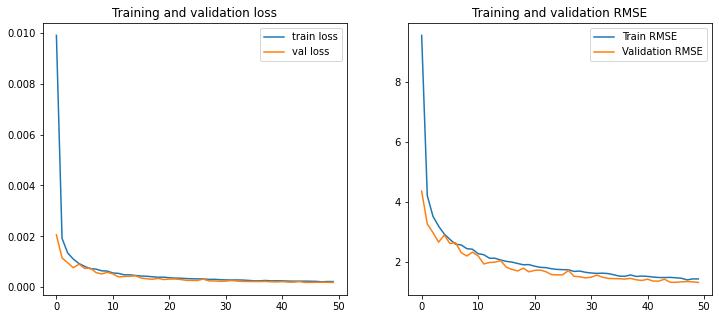

In [31]:
# with new augmentations
criterion = masked_MSELoss
model = resnet18_model_new()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0E-04)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95, verbose=True)

train_model(dataloader, dataloader_val, criterion=criterion, epochs=EPOCHS_NUM, schedular=scheduler)

## Explore Validation loss
see the errors on the last modul

show_dataset_RMSE(model, val_face_dataset)

In [67]:
show_dataset_RMSE(model.to(device), val_face_dataset, masked=True)

RuntimeError: ignored

the errors we can see:
* bad labeling of ground trouth (#389)
* face are at small porsion of the image (#1276, #520, #1350)
* face to the side (#1402, #565, #665)

## Run Model on Test set
run the model on the test dataset, analyze the results and create submission file


#### First time only

In [58]:
## on the first time
# !ls
# !unzip ./test.zip -d .

#### Extract the test dataset

In [59]:
test_csv_name = 'test.csv'
test_df = pd.read_csv(test_csv_name)
face_dataset_test = FacialKeypointsDataset(df=test_df, transform = None, test = True)

batch_size=128
test_dataloader = DataLoader(face_dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

#### create predicitons for test set

In [60]:
torch.cuda.empty_cache()

In [61]:
GPU_FOR_TESTING=False

In [62]:
def create_test_results(test_model, test_dl):    
    device_for_test = device if GPU_FOR_TESTING else 'cpu'
    test_model.to(device_for_test)
    all_predicionts = []
    test_model.eval()
    with torch.no_grad():
        for images in test_dl:            
            predictions = test_model(images.to(device_for_test))
            all_predicionts.append(predictions)            
        all_predicionts = torch.cat(all_predicionts)                    
    all_predicionts = torch.clip(all_predicionts,0.0, 1.0)    
    return all_predicionts

test_res = create_test_results(model, test_dataloader)

#### Visualize Test images with predictions

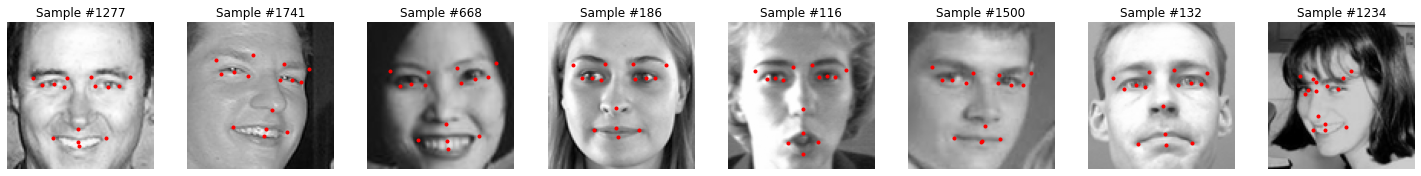

In [63]:
fig = plt.figure(figsize=(20,8))
for i in range(len(test_res)):    
    img_inx = random.randrange(len(test_res))    
    ax = fig.add_subplot(1, 8, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(img_inx))
    ax.axis('off')    
    show_image_keypoints(face_dataset_test[img_inx], test_res[img_inx].cpu().data.view(15,2).numpy())
    if i == 7: plt.show(); break
    # plt.tight_layout()

## Creating submission file

In [64]:
id_lookup = pd.read_csv('IdLookupTable.csv')
features = list(df.keys())[:-1] 
features_dict = {feature:i for i,feature in enumerate(features)}

In [65]:
def create_submission(results):
    test_res_flt = results.reshape(-1,2*15).cpu().data.numpy()
    test_res_flt *=96 # aligning to image size
    for row in range(len(id_lookup)):
        rowId = id_lookup['RowId'][row]
        imageId = id_lookup['ImageId'][row]
        featureName = id_lookup['FeatureName'][row]
        featureNameinx = features_dict[featureName]
        id_lookup['Location'][row] = test_res_flt[imageId-1][featureNameinx]              

    submission = id_lookup[['RowId', 'Location']]
    submission.to_csv('Submission.csv', index=False)

create_submission(test_res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Kaggle score


Summary

Model and method            |  Kaggle Score [public/private]
-------------------|------------------
custom model       | 4.006/3.826
Resnet Model       | 3.386/3.251
Resnet with masked loss function (with amsgra) | 1.981/1.714
Resnet with masked loss function and scheduler | 2.177/2.059
updated Resnet with masked loss function, scheduler, adittional augmentations | 1.854/1.705

The best result echieved 1.854/1.705
is **ranked #5/9** out of 175 teams

